In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    %load_ext autoreload
%autoreload 2

In [2]:
from utils.core import Load_data
import pandas as pd
import numpy as np
from Model.preprocessing.pipelines import Data_Process
from Model.preprocessing.datasetManager import DatasetManger
from Model.base.train import cross_validation
from Model.base.model import make_model
from Model.base.logger import LoggerManager
import tensorflow as tf
from Model.base.evaluator import EvalutionClassifer, Drow, Drow_mean, Save_fig
from Model.base.augmentation import Augmentation, Strategies
from ydata_profiling import ProfileReport

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
batch_size = 32
test_size = 0.20
val_size = 0.20
epoch = 600
lr= 0.01
cv = 10
model_description = "nothing"
model_number =1
Shuffle = True
Scheduler = True
METRICS = [
    tf.keras.metrics.BinaryAccuracy,
    tf.keras.metrics.Precision,
    tf.keras.metrics.Recall,
    #tf.keras.metrics.F1Score
]
loss = tf.keras.losses.BinaryCrossentropy
trained_modelPath = "./trained_model"
plotPath = "./plots"

In [4]:
dataset_pd = pd.read_csv("../dataset/FullDatasetAndWavlet.csv", index_col="annot_id")
dataset_pd.loc["125_"] = dataset_pd.loc["125_"].fillna(0.9)
#dataset_pd = dataset_pd.drop(["annot_id"], axis=1)
#dataset_pd =dataset_pd.drop(["size_x", "size_y", "size_z"], axis=1)

In [5]:
column_interest = [
    'ti-rads_level',
    'original_ngtdm_Coarseness',
    'wavelet-HH_glcm_MaximumProbability',
    'wavelet-LH_glszm_LargeAreaHighGrayLevelEmphasis',
    'sex',
    'age',
    'size_x',
    'ti-rads_margin',
    'ti-rads_echogenicfoci',
    'wavelet-LH_glcm_SumEntropy',
    'original_firstorder_Kurtosis',
    'wavelet-LL_glszm_LargeAreaLowGrayLevelEmphasis',
    'wavelet-HL_firstorder_Energy',
    'size_y',
    'ti-rads_shape',
    'wavelet-HH_glrlm_RunLengthNonUniformityNormalized',
    'size_z',
    'wavelet-LL_glcm_MCC',
    'wavelet-HH_firstorder_Variance',
    'wavelet-HL_glszm_HighGrayLevelZoneEmphasis',
    'wavelet-HH_glszm_LargeAreaHighGrayLevelEmphasis',
    'original_firstorder_InterquartileRange',
    'wavelet-HL_glrlm_ShortRunLowGrayLevelEmphasis',
    'wavelet-HL_glszm_LargeAreaHighGrayLevelEmphasis',
    'original_firstorder_Skewness',
    'wavelet-LH_gldm_DependenceEntropy',
    'original_glszm_LargeAreaLowGrayLevelEmphasis',
    'wavelet-HH_glrlm_RunLengthNonUniformity',
    'original_shape2D_Sphericity',
    'wavelet-HL_firstorder_Median'
]

X = dataset_pd[column_interest]



Y = dataset_pd['histopath_diagnosis'].astype(np.float32)

In [6]:
managerdataset = DatasetManger(X, Y, batch_size=batch_size, n_splits=2, test_size=test_size)
features_train, label_train, features_test, label_test = managerdataset.split()[0]

In [7]:
categorical_features = ["sex"]  # remvoed by mrmr "location" 

numerical_features =["ti-rads_level", "age"]#["ti-rads_level", "size_x", "size_y", "size_z", "age" ]

Ti_rads_featurea = [ "ti-rads_margin", "ti-rads_shape",
                    "ti-rads_echogenicfoci"]  # removed by mrmr "ti-rads_composition", "ti-rads_echogenicity"

numerical_features = list(X[X.columns[~X.columns.isin(
    categorical_features + Ti_rads_featurea)]].columns)

scaler = Data_Process(features_train, categorical_features,
                      numerical_features, Ti_rads_featurea)
features_train = scaler.fit_transform()
features_test = scaler.transform(features_test)

In [8]:
features_train.isna().any(axis=None)

False

In [9]:
augmentor_training = Augmentation(features_train, label_train)
features_train, label_train = augmentor_training.generate(Strategies.OverSampling)
augmentor_test = Augmentation(features_test, label_test)
features_test, label_test = augmentor_test.generate(Strategies.OverSampling)


In [10]:
"""features_test["target"] = label_test
features_train["Target"] = label_train
features_test.to_csv("./../dataset/test.csv")
features_train.to_csv("./../dataset/train.csv")

profile = ProfileReport(features_train, title="training_dataset")
profile.to_file(output_file="pandas_profilingtrain.html")

profile = ProfileReport(features_test, title="test_dataset")
profile.to_file(output_file="pandas_profilingtest.html")"""

'features_test["target"] = label_test\nfeatures_train["Target"] = label_train\nfeatures_test.to_csv("./../dataset/test.csv")\nfeatures_train.to_csv("./../dataset/train.csv")\n\nprofile = ProfileReport(features_train, title="training_dataset")\nprofile.to_file(output_file="pandas_profilingtrain.html")\n\nprofile = ProfileReport(features_test, title="test_dataset")\nprofile.to_file(output_file="pandas_profilingtest.html")'

In [11]:
#features_train["target"] = label_train

In [12]:
#corr = features_train.corr()
#corr.style.background_gradient(cmap='coolwarm')

In [13]:
model = make_model(features_train.keys(), batch_size)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 categorical__sex_Female (I  [(32, 1, 1)]                 0         []                            
 nputLayer)                                                                                       
                                                                                                  
 categorical__sex_Male (Inp  [(32, 1, 1)]                 0         []                            
 utLayer)                                                                                         
                                                                                                  
 num__ti-rads_level (InputL  [(32, 1, 1)]                 0         []                            
 ayer)                                                                                      

In [14]:
results = cross_validation(model, METRICS, loss, epoch=epoch, batch_size=batch_size, x=features_train, y=label_train, cv=cv, test_size=val_size, lr=lr, Scheduler=Scheduler, verbose=1, Shuffle=Shuffle)

Epoch 1/600

618/618 [==============================] - 7s 7ms/step - loss: 0.3843 - BinaryAccuracy: 0.8271 - Precision: 0.8055 - Recall: 0.8624 - val_loss: 0.2824 - val_BinaryAccuracy: 0.8837 - val_Precision: 0.8343 - val_Recall: 0.9575 - lr: 0.0099
Epoch 2/600
618/618 [==============================] - 4s 7ms/step - loss: 0.2719 - BinaryAccuracy: 0.8922 - Precision: 0.8655 - Recall: 0.9287 - val_loss: 0.2142 - val_BinaryAccuracy: 0.9168 - val_Precision: 0.8740 - val_Recall: 0.9741 - lr: 0.0098
Epoch 3/600
618/618 [==============================] - 4s 6ms/step - loss: 0.2340 - BinaryAccuracy: 0.9094 - Precision: 0.8876 - Recall: 0.9376 - val_loss: 0.1933 - val_BinaryAccuracy: 0.9253 - val_Precision: 0.8881 - val_Recall: 0.9733 - lr: 0.0097
Epoch 4/600
618/618 [==============================] - 3s 6ms/step - loss: 0.2278 - BinaryAccuracy: 0.9141 - Precision: 0.8951 - Recall: 0.9381 - val_loss: 0.1653 - val_BinaryAccuracy: 0.9379 - val_Precision: 0.9025 - val_Recall: 0.9818 - lr: 0.0096

In [15]:
models = [result["model"] for result in results]
training_sets = [result["train_set"] for result in results]
validation_sets = [result["test_set"] for result in results]
history = [result['monitor'] for result in results]
index_mdoel = 0

In [16]:
evaluator_train = EvalutionClassifer(models, training_sets)

618/618 [==============================] - 1s 2ms/step


{'BinaryAccuracy': 0.50677866, 'Precision': 0.5066946, 'Recall': 0.5130514}

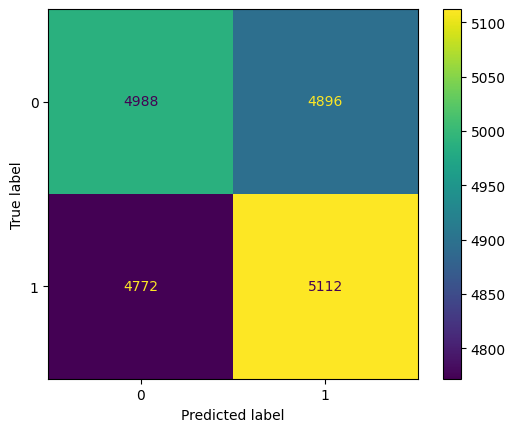

In [17]:
evaluator_train.Draw_Confusion_Matrics(i=index_mdoel)
evaluator_train.Calculate_metrics(METRICS, index_mdoel)

(<Figure size 1200x600 with 1 Axes>, <Axes: >)

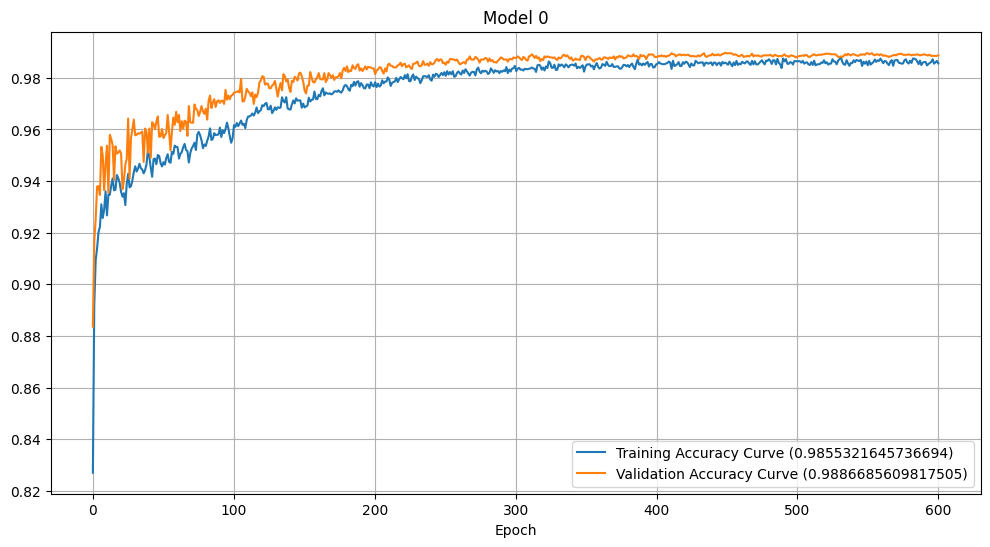

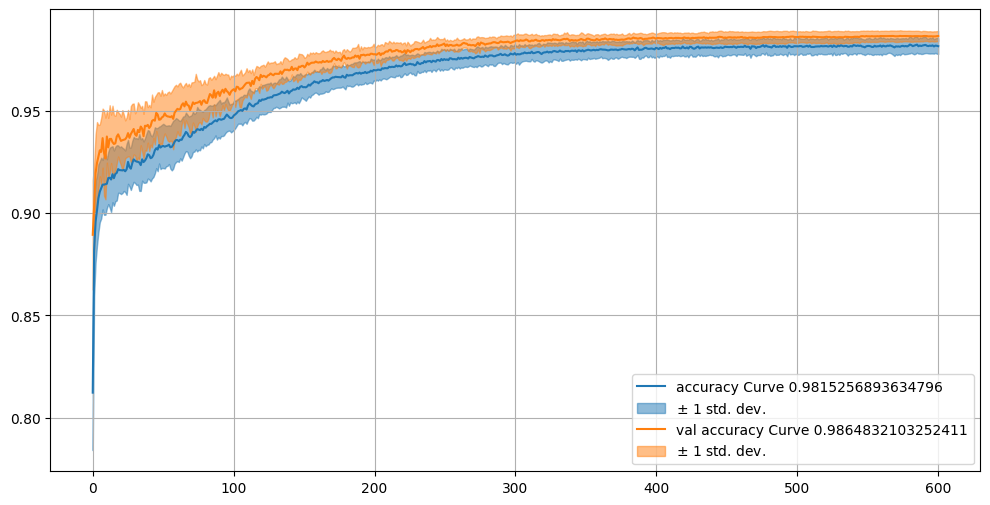

In [18]:
data_dic = {
    "Training Accuracy": history[index_mdoel].history["BinaryAccuracy"],
    "Validation Accuracy": history[index_mdoel].history["val_BinaryAccuracy"]
}

Drow(data_dic, epoch, str(index_mdoel))

#Save_fig(plotPath, model_number, ["Accuracy"])

history
data_dic = {
    "accuracy": [x.history["BinaryAccuracy"] for x in history],
    "val accuracy": [x.history["val_BinaryAccuracy"] for x in history]
}

Drow_mean(data_dic, epoch)

(<Figure size 1200x600 with 1 Axes>, <Axes: >)

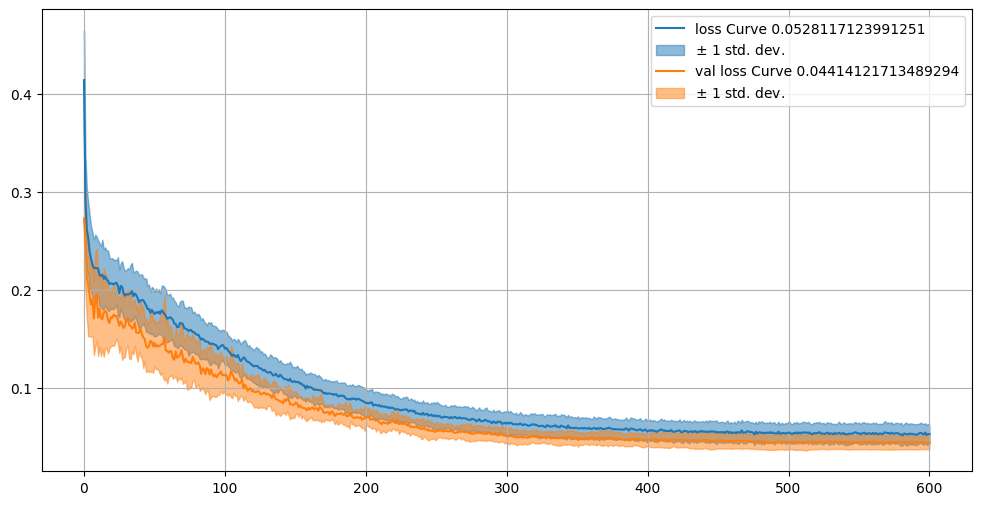

In [19]:
data_dic = {
    "loss": [x.history["loss"] for x in history],
    "val loss":[x.history["val_loss"] for x in history]
}

Drow_mean(data_dic, epoch)
#Save_fig(plotPath, model_number, ["mean","Loss"])

(<Figure size 1200x600 with 1 Axes>, <Axes: >)

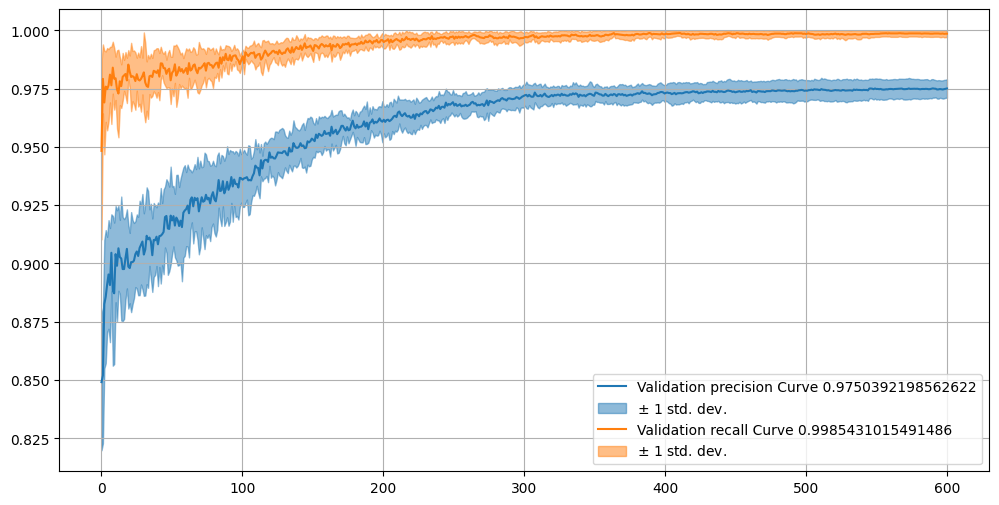

In [20]:
data_dic = {
    "Validation precision": [x.history["val_Precision"] for x in history],
    "Validation recall": [x.history["val_Recall"] for x in history]
}
Drow_mean(data_dic, epoch)
#Save_fig(plotPath, model_number, ["validation","recall", "precision"])

In [21]:
evaluator_validationset = EvalutionClassifer(models, validation_sets)

155/155 [==============================] - 0s 2ms/step


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Mean ROC curve with variability\n(Positive label tumor type)'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

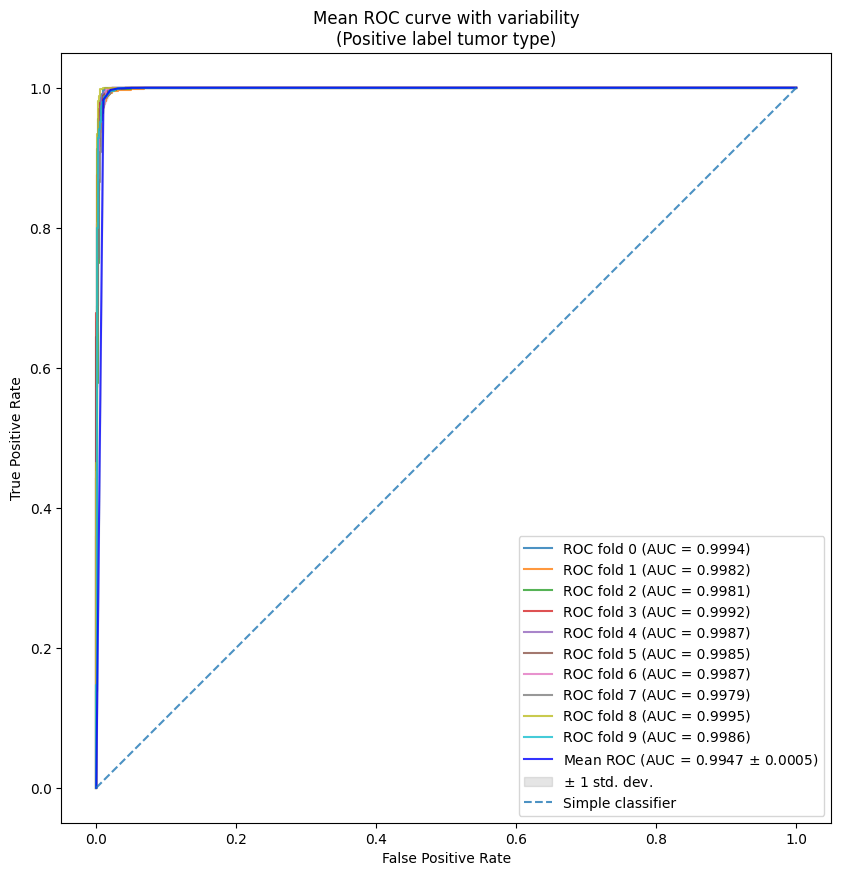

In [22]:
evaluator_validationset.Draw_ROC_ALL()

155/155 [==============================] - 0s 2ms/step


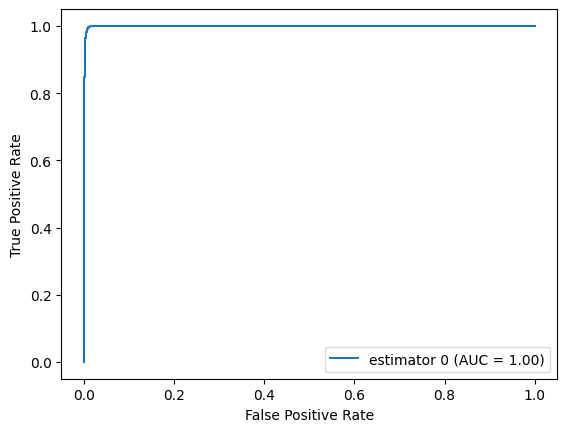

In [23]:
evaluator_validationset.Draw_ROC(index_mdoel)

model number 0
155/155 [==============================] - 0s 2ms/step
model number 1
155/155 [==============================] - 0s 2ms/step
model number 2
155/155 [==============================] - 0s 2ms/step
model number 3
155/155 [==============================] - 0s 2ms/step
model number 4
155/155 [==============================] - 0s 2ms/step
model number 5
155/155 [==============================] - 0s 2ms/step
model number 6
155/155 [==============================] - 0s 2ms/step
model number 7
155/155 [==============================] - 0s 2ms/step
model number 8
155/155 [==============================] - 0s 2ms/step
model number 9
155/155 [==============================] - 0s 2ms/step


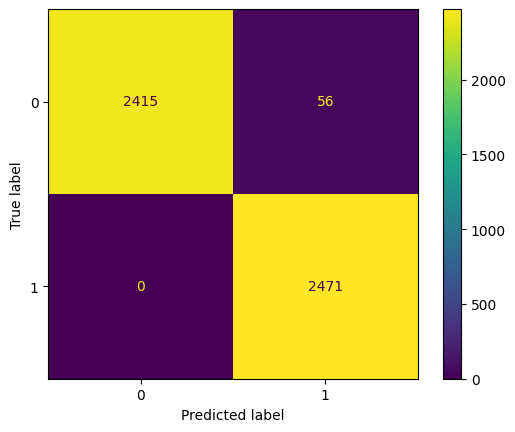

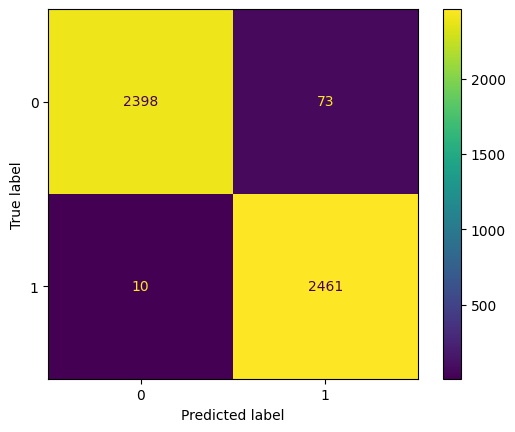

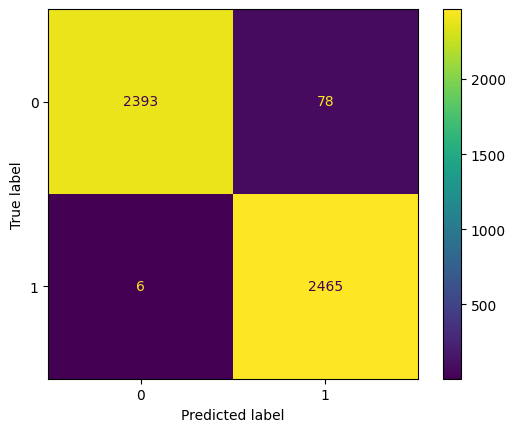

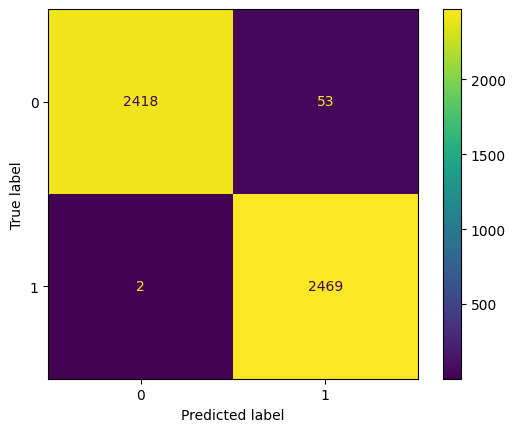

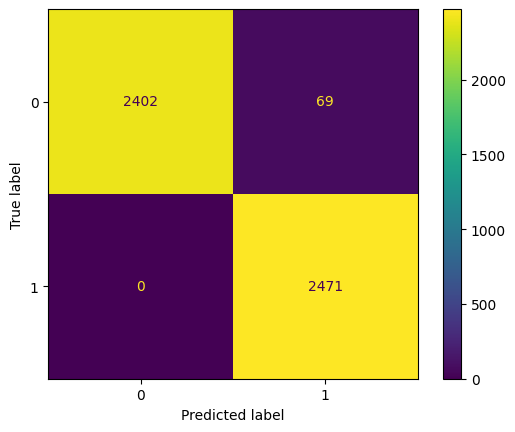

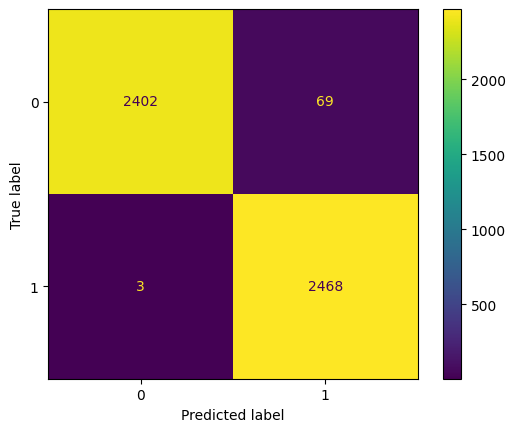

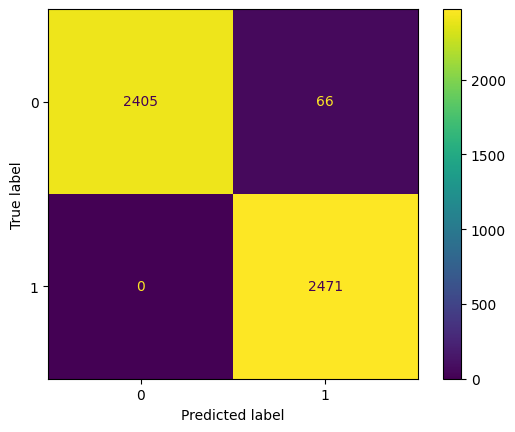

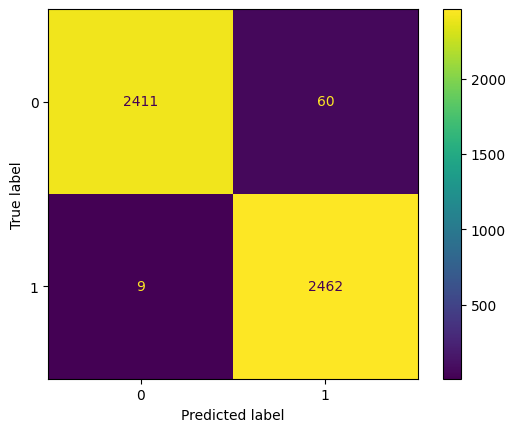

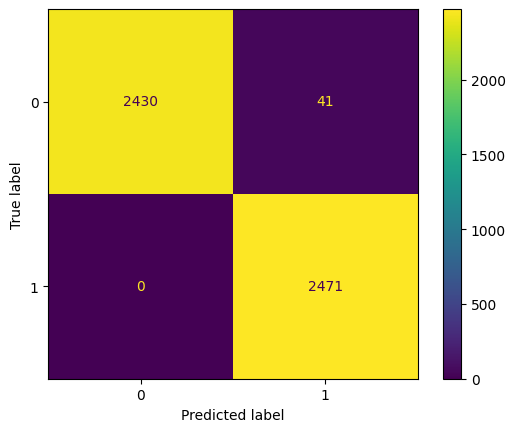

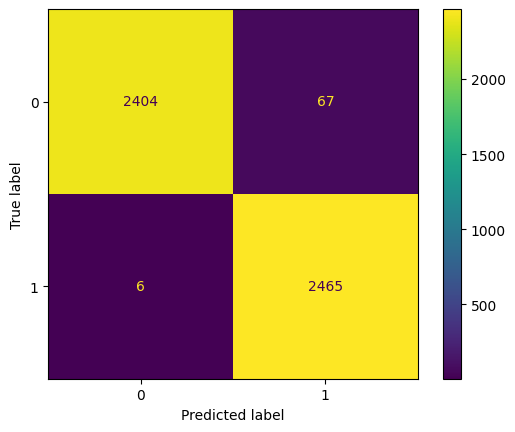

In [24]:
for x in range(cv):
    print("model number "+str(x))
    evaluator_validationset.Draw_Confusion_Matrics(x)
    evaluator_validationset.Calculate_metrics(METRICS, x)

In [25]:
test_dataset = managerdataset.convert_df_to_dataset(features_test, label_test)
test_dataset = [test_dataset for x in range(cv)]
evaluator_test = EvalutionClassifer(models, test_dataset)

194/194 [==============================] - 0s 2ms/step


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Mean ROC curve with variability\n(Positive label tumor type)'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

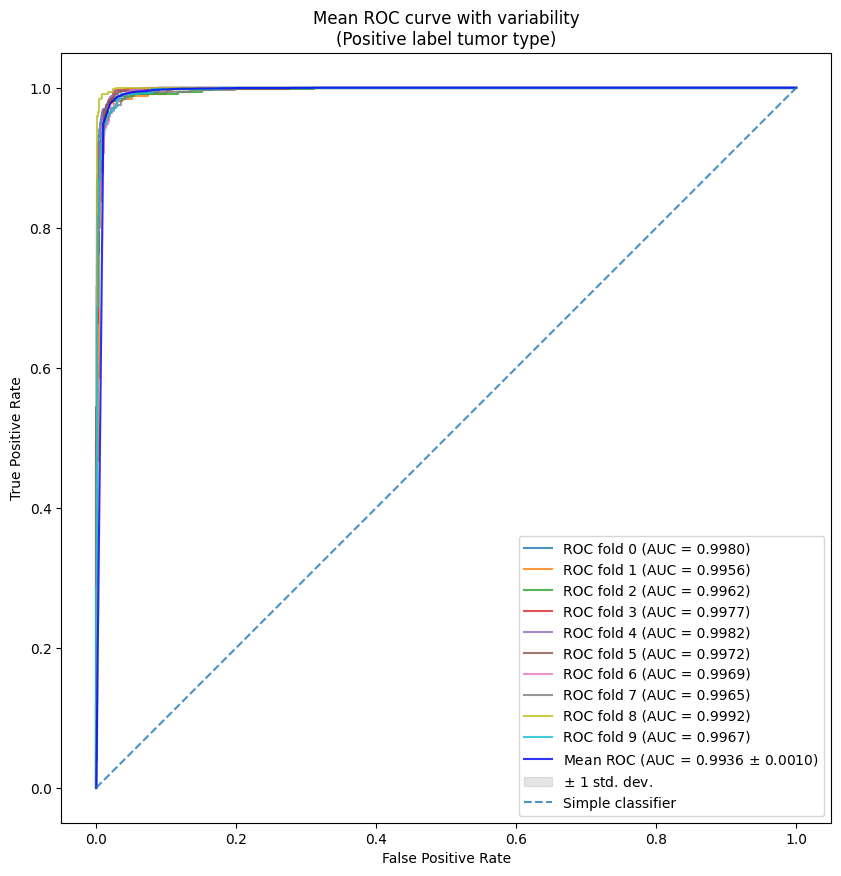

In [26]:
evaluator_test.Draw_ROC_ALL()

194/194 [==============================] - 0s 2ms/step


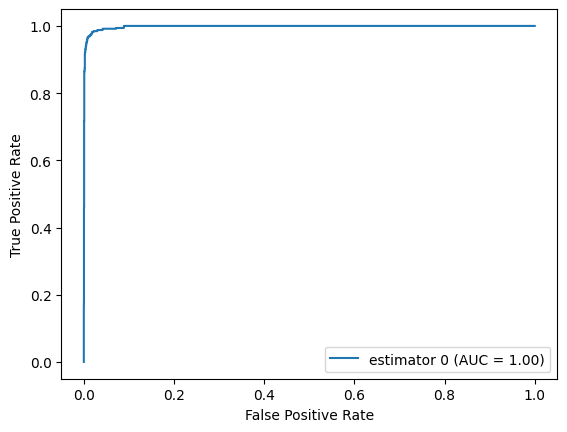

In [27]:
evaluator_test.Draw_ROC(index_mdoel)

model number 0
194/194 [==============================] - 0s 2ms/step
model number 1
194/194 [==============================] - 0s 2ms/step
model number 2
194/194 [==============================] - 0s 2ms/step
model number 3
194/194 [==============================] - 0s 2ms/step
model number 4
194/194 [==============================] - 0s 2ms/step
model number 5
194/194 [==============================] - 0s 2ms/step
model number 6
194/194 [==============================] - 0s 2ms/step
model number 7
194/194 [==============================] - 0s 2ms/step
model number 8
194/194 [==============================] - 0s 2ms/step
model number 9
194/194 [==============================] - 0s 2ms/step


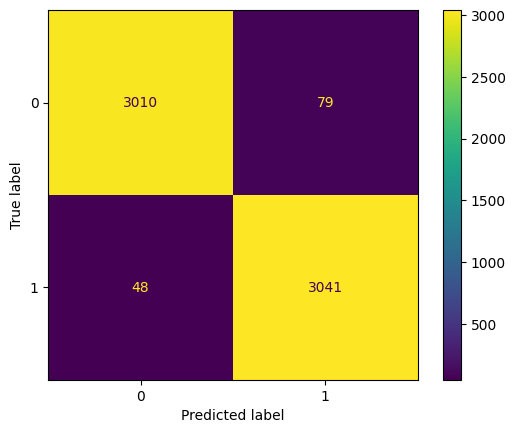

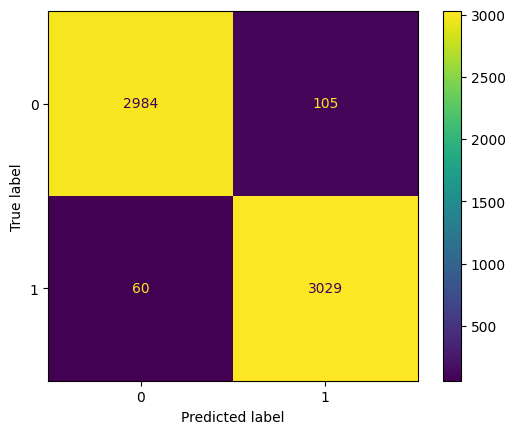

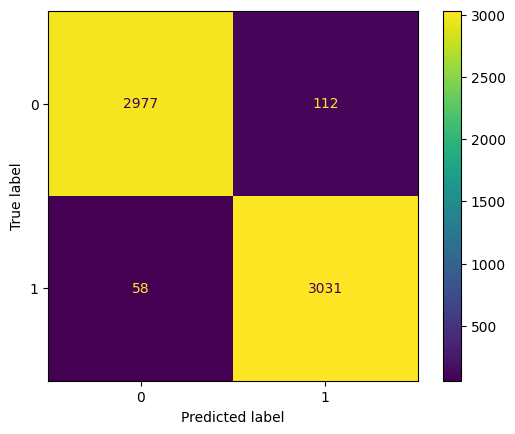

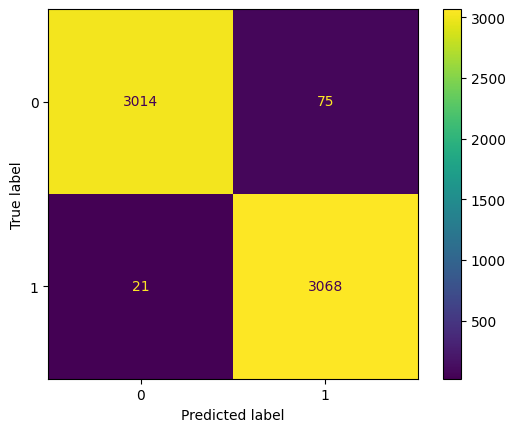

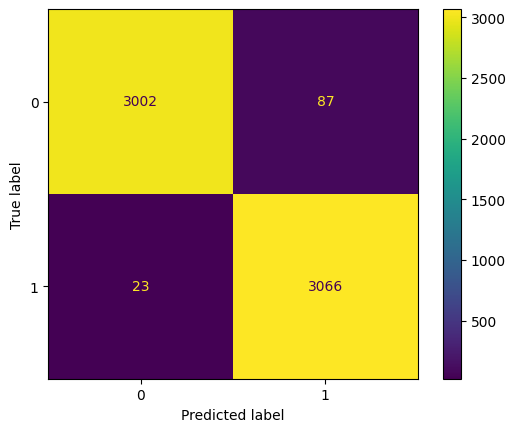

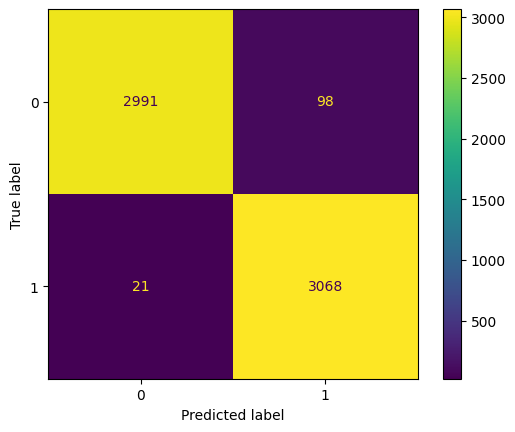

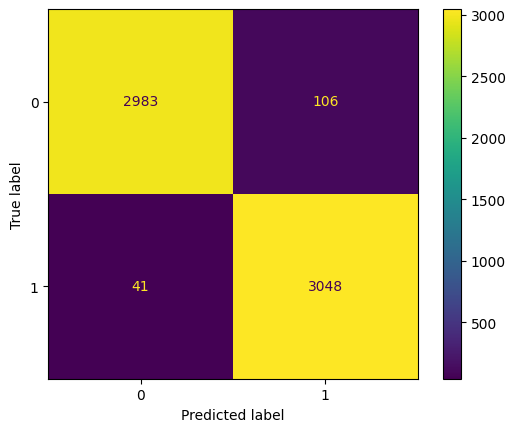

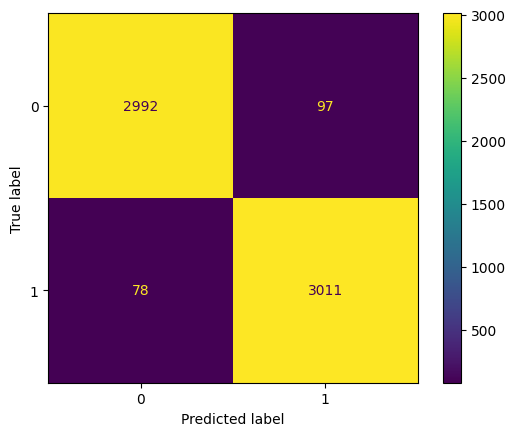

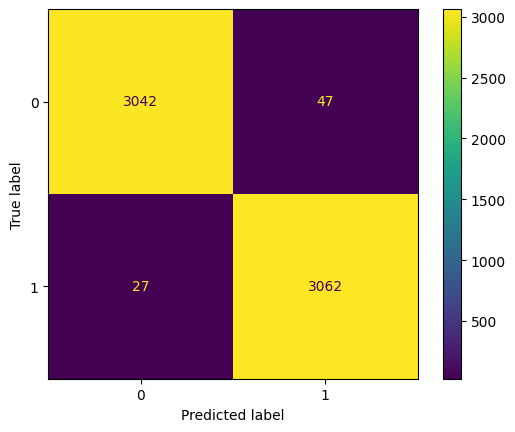

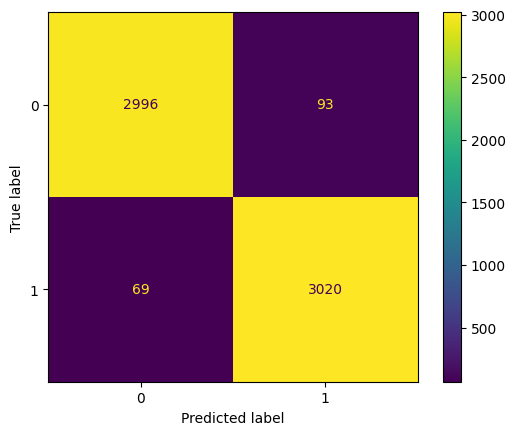

In [28]:
for x in range(cv):
    print("model number "+str(x))
    evaluator_test.Draw_Confusion_Matrics(x)
    evaluator_test.Calculate_metrics(METRICS, x)

In [29]:
checkpoint_path = "{0}model{1}.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)
for index_model in range(len(models)):
    models[index_model].save(os.path.join(trained_modelPath, checkpoint_path.format(model_number, index_model)))

In [30]:
logger = LoggerManager("./log/info.log")
logger.log_info(f"model_number:{model_number}, batch:{batch_size}, test_size:{test_size}, val_size:{val_size}, epoch:{epoch}, lr:{lr}, loss:{loss.__name__}, model description:{model_description} ")
